# UNSUPERVISED LEARNING ON CITY OF SCOTTSDALE CITATIONS

### To Investigate:

Am I able to spot clusters when people of specific demographics receive certain types of citations?  To achieve this goal I will:

1. Apply dimensionality reduction techniques to visualize the observations.
1. Apply clustering techniques to group together similar observations.

### Data Source
On a weekly basis the City of Scottsdale Police Department publishes a [dataset](http://data.scottsdaleaz.gov/dataset/police-citations)* which includes one prior years worth citations.  These citations are largely made up of vehicle related infractions such as speeding.  


I downloaded the data in September 2018, September 2019, and January 2020.  In raw format the combined dataset includes just over XXK rows and 22 columns.  For privacy issues, the City of Scottsdale does not release citation data for anyone under 18.  

<br/>

*Contains information from the City of Scottsdale Open Database Portal, which is made available here under the [Open Database License](http://www.scottsdaleaz.gov/AssetFactory.aspx?did=69351).


## DATA PREPROCESSING

In [154]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import glob
pd.set_option('display.max_columns', None)
%matplotlib inline 
# plt.style.use('bmh')
sns.set(style='darkgrid')
plt.rcParams['patch.edgecolor'] = 'none'

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

AttributeError: module 'seaborn' has no attribute 'rcParams'

In [2]:
# read in csv files
files = glob.glob('data/*.csv')

citations = pd.concat([pd.read_csv(f) \
                      for f in files], sort=True)

In [3]:
# convert column labels to lower case and remove spaces from column names
citations.columns = citations.columns.str.replace(' ', '_')
citations.columns = map(str.lower, citations.columns)

In [4]:
# remove duplicate citations due to overlap in data being downloaded
citations.drop_duplicates('citation_#', inplace=True)

In [5]:
# change data type of age from object to number
citations.cited_person_age = pd.to_numeric(citations.cited_person_age, errors='coerce')

In [6]:
# convert citation date to datetime format
citations['citation_date'] = pd.to_datetime(citations['citation_date'])

# create month column
citations['month'] = citations['citation_date'].dt.month

# create day of week column
citations['day_of_week'] = citations['citation_date'].dt.dayofweek

# create day of week column
citations['week_of_year'] = citations['citation_date'].dt.weekofyear

# extract the hour of the day from the citation time column
citations['hour_of_day'] = citations['citation_time'].apply(lambda x: str(x)[-4:-2])

# replace blanks with 0
# this happened for citations that took place during the hour of 12am
citations.loc[citations.hour_of_day == '', 'hour_of_day'] = 0
# change data type of hour from object to number
citations.hour_of_day = pd.to_numeric(citations.hour_of_day)

In [7]:
# one citation has no age
# drop citations where age isn't provided

citations.dropna(subset=['cited_person_age'], inplace=True)

In [8]:
citations.cited_person_sex.value_counts()

M    35199
F    21220
U       14
Name: cited_person_sex, dtype: int64

In [14]:
# 14 citations have no gender
# drop citations where gender isn't binary
citations.drop(citations[citations.cited_person_sex == 'U'].index, inplace=True)

In [15]:
# verify non-binary genders have been dropped
citations.cited_person_sex.value_counts()

M    35184
F    21216
Name: cited_person_sex, dtype: int64

In [62]:
# realign index afer removing above row
# otherwise this created an error for Jenkspy below
# citations.reset_index(drop=True, inplace=True)

In [16]:
# how many rows and columns are in the dataset?
citations.shape

(56403, 26)

# Identify 5 citations that I think will have specific demographics associated with them

    Fail to Yield Turning Left at Intersection
    Fail to Stop at Stop Sign
    DUI-Impaired to Slightest Degree
    Failure to Control Speed to Avoid A Collision
    Exceed Limit By More Than 20mph

In [17]:
citation_groups = [
    'Fail to Yield Turning Left at Intersection',
    'Fail to Stop at Stop Sign',
    'DUI-Impaired to Slightest Degree',
    'Failure to Control Speed to Avoid A Collision',
    'Exceed Limit By More Than 20mph'
]

In [18]:
# subset full citation dataset with only the top 20 citations by count
five_citations = citations[citations.charge_description.isin(citation_groups)]

In [19]:
five_citations.shape

(8784, 26)

In [21]:
five_citations.head()

,arizona_statute_code,beat,charge_description,citation_#,citation_date,citation_time,citation_type_code,citation_type_description,cited_person,cited_person_age,cited_person_ethnicity,cited_person_race,cited_person_sex,city,district,officer_badge_#,state,street,street_number,zip,zone,tcmainid,month,day_of_week,week_of_year,hour_of_day
27,28-701A,1.0,Failure to Control Speed to Avoid A Collision,2087778,2019-07-15,1750,CV,Civil Traffic,"Flaaen-Hanna, Lynn",58.0,N,W,F,Scottsdale,D1,1501,AZ,N Hayden Rd / E McKellips Rd,xxx,NaN,103,662835,7,0,29,17
29,28-701.02A2,10.0,Exceed Limit By More Than 20mph,2087820,2019-07-15,1920,CT,Criminal Traffic,"Viadero, Patricio",22.0,N,W,M,Scottsdale,D3,1274,AZ,N Hayden Rd / E Via De Ventura,xxx,NaN,2606,662839,7,0,29,19
31,28-701.02A2,5.0,Exceed Limit By More Than 20mph,2089352,2019-07-15,1927,CT,Criminal Traffic,"Rogers, Sierra",22.0,N,W,F,Scottsdale,D2,1306,AZ,E Indian School Rd,8xxx,NaN,814,662842,7,0,29,19
32,28-701.02A2,1.0,Exceed Limit By More Than 20mph,2084967,2019-07-15,2030,CT,Criminal Traffic,"Sanchez Lopez, JOrge",19.0,H,W,M,Scottsdale,D1,1522,AZ,N Scottsdale Rd / E Skysong Bl,xxx,NaN,301,662845,7,0,29,20
36,28-701A,17.0,Failure to Control Speed to Avoid A Collision,2083769,2019-07-13,1126,CV,Civil Traffic,"Zajac, Rachel",22.0,N,W,F,Scottsdale,D4,1237,AZ,E Frank Lloyd Wright Bl / L101 Frontage Rd Nb,xxx,85260,3404,662851,7,5,28,11


In [35]:
# assign X and y values
X = pd.get_dummies(five_citations[['citation_time', 'cited_person_sex']])

y = five_citations['charge_description'].astype('category').cat.codes

In [36]:
X.head()

,citation_time,cited_person_sex_F,cited_person_sex_M
27,1750,1,0
29,1920,0,1
31,1927,1,0
32,2030,0,1
36,1126,1,0


## VISUALIZE CLUSTERS

### PCA

In [37]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

In [38]:
y.value_counts()

0    2742
4    2670
2    1469
1    1257
3     646
dtype: int64

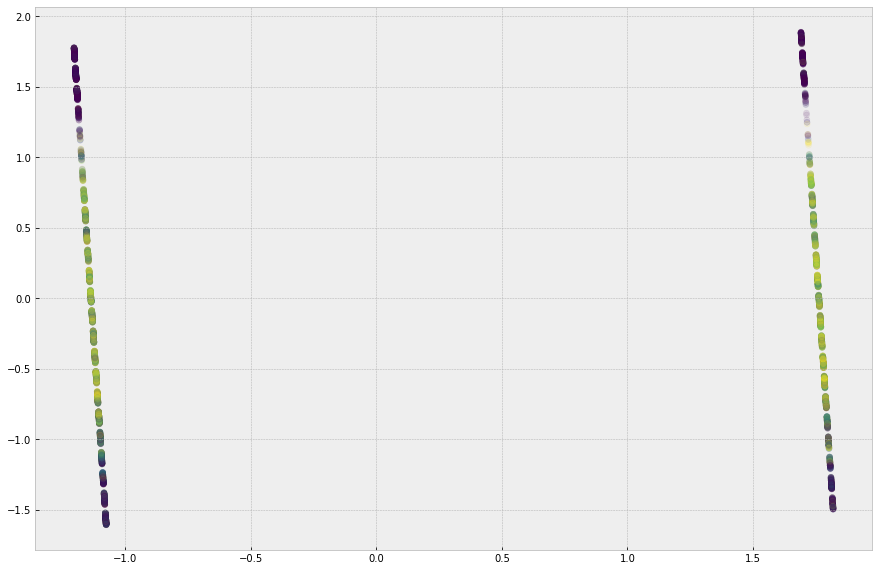

In [39]:
plt.figure(figsize=(15,10))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha=.1)

In [118]:
X_pca

array([[ 1.46479816,  1.07184262],
       [-0.79252016, -0.61986277],
       [ 1.45773801,  1.0308397 ],
       ...,
       [ 1.99515163,  0.28768478],
       [-0.16574893, -1.52828919],
       [ 2.15977609,  0.17772058]])

### t-SNE

In [40]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8784 samples in 0.006s...
[t-SNE] Computed neighbors for 8784 samples in 0.250s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8784
[t-SNE] Computed conditional probabilities for sample 2000 / 8784
[t-SNE] Computed conditional probabilities for sample 3000 / 8784
[t-SNE] Computed conditional probabilities for sample 4000 / 8784
[t-SNE] Computed conditional probabilities for sample 5000 / 8784
[t-SNE] Computed conditional probabilities for sample 6000 / 8784
[t-SNE] Computed conditional probabilities for sample 7000 / 8784
[t-SNE] Computed conditional probabilities for sample 8000 / 8784
[t-SNE] Computed conditional probabilities for sample 8784 / 8784
[t-SNE] Mean sigma: 1.970953
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.287128
[t-SNE] KL divergence after 300 iterations: 1.562699


In [117]:
tsne_results

array([[ 1.3558173 , -0.72297513],
       [ 5.8929887 , -1.3974224 ],
       [-2.0601377 ,  0.2922645 ],
       ...,
       [ 0.8910269 ,  4.952217  ],
       [ 6.804119  ,  1.8327006 ],
       [-1.2312789 ,  4.383005  ]], dtype=float32)

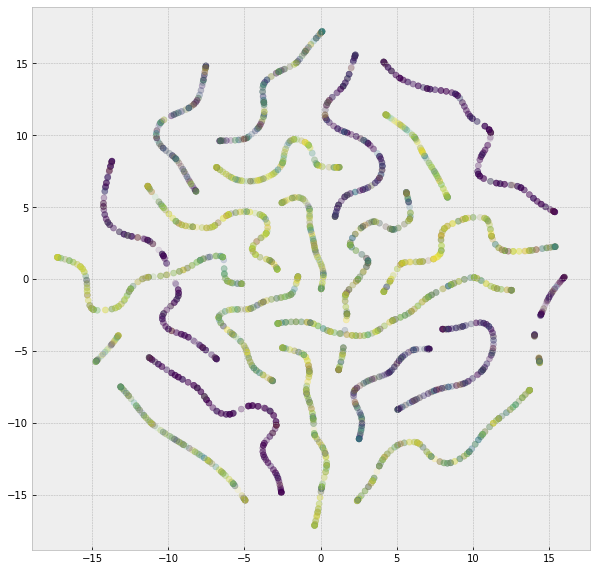

In [42]:
plt.figure(figsize=(10, 10))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=.1, c=y)

### UMAP

In [44]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X)

In [56]:
umap_results[:, 0].size

8784

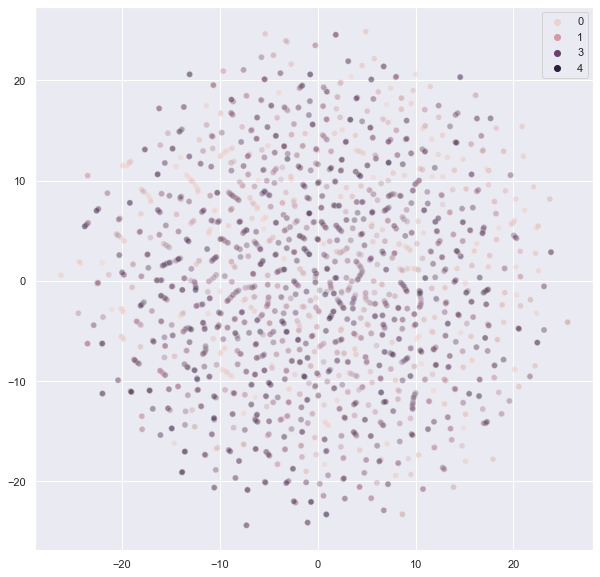

In [57]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], alpha=.1, hue=y)
plt.legend(loc='best')

In [58]:
umap_results = umap.UMAP(n_neighbors=20,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X)

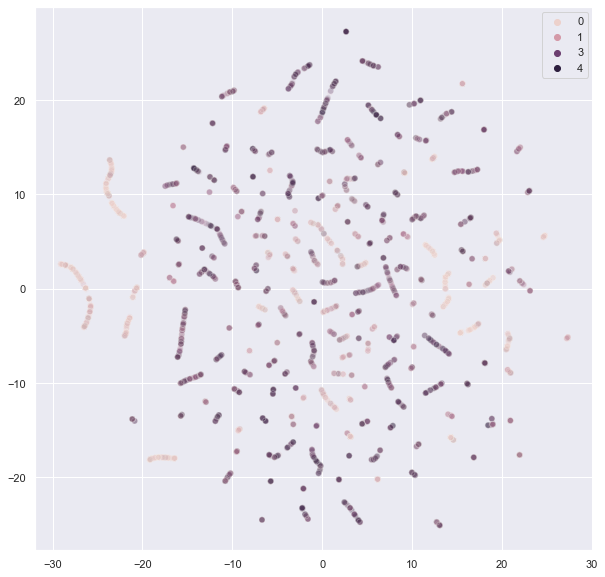

In [59]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], alpha=.1, hue=y)
plt.legend(loc='best')

## GROUP CLUSTERS AND EXAMINE FIT OF GROUPINGS

In [60]:
# create df to hold results of each iteration

rows = ['hierarchical - ward',
       'hierarchical - complete',
       'hierarchical - average',
       'k-means',
       'gaussian - full',
       'gaussian - tied',
       'gaussian - diag',
       'gaussian - spherical']

columns = ['ARI',
          'silhouette']

results_df = pd.DataFrame(index=rows,
                         columns=columns)

## K-means with 5 clusters

In [61]:
# silhouette
labels = KMeans(n_clusters=5).fit_predict(X_std)

results_df.loc['k-means', 'silhouette'] = round(metrics.silhouette_score(X_std, labels, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, labels, metric='euclidean'), 3)

0.615

In [62]:
# ARI
y_pred = KMeans(n_clusters=5).fit_predict(X_std)

results_df.loc['k-means', 'ARI'] = round(metrics.adjusted_rand_score(y, y_pred), 3)
round(metrics.adjusted_rand_score(y, y_pred), 3)

0.069

## Agglomerative methods

### 1. Ward - In general, this method tends to find clusters of similar size

In [63]:
# Defining the agglomerative clustering
# remember, ward only works with Euclidian
agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=5)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [64]:
# examine Adjusted Rand Index (ARI) and the silhouette scores
results_df.loc['hierarchical - ward', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.059

In [65]:
# examine silhouette score
results_df.loc['hierarchical - ward', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.585

### 2. Complete - Clusters tend to be comprised of highly similar observations, making the resulting groups quite compact.

In [66]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=5)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [67]:
# examine Adjusted Rand Index (ARI) and the silhouette scores
results_df.loc['hierarchical - complete', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.032

In [68]:
# examine silhouette score
results_df.loc['hierarchical - complete', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.604

### 3. Average - it tends to create larger groups than the complete method. Moreover, the clusters can be different sizes and shapes in contrast to the Ward method.

In [69]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='cosine',
                                      n_clusters=5)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [70]:
# examine Adjusted Rand Index (ARI) and the silhouette scores
results_df.loc['hierarchical - average', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.036

In [71]:
# examine silhouette score
results_df.loc['hierarchical - average', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.611

## Gausian Mixture Modeling
Explore each covariance_type parameter:

 1. full: This is the default. Each component has its own general covariance matrix.
 1. tied: All components share the same general covariance matrix.
 1. diag: Each component has its own diagonal covariance matrix.
 1. spherical: Each component has its own single variance.

## full

In [72]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [73]:
# Examine ARI and silhouette score
results_df.loc['gaussian - full', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.598

In [74]:
results_df.loc['gaussian - full', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.052

## tied

In [75]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123, covariance_type='tied')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [76]:
# Examine ARI and silhouette score
results_df.loc['gaussian - tied', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.62

In [77]:
results_df.loc['gaussian - tied', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.042

## diag

In [78]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123, covariance_type='diag')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [79]:
# Examine ARI and silhouette score
results_df.loc['gaussian - diag', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.598

In [80]:
results_df.loc['gaussian - diag', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.052

## spherical

In [81]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123, covariance_type='spherical')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [82]:
# Examine ARI and silhouette score
results_df.loc['gaussian - spherical', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.619

In [83]:
results_df.loc['gaussian - spherical', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.04

In [84]:
results_df

,ARI,silhouette
hierarchical - ward,0.059,0.585
hierarchical - complete,0.032,0.604
hierarchical - average,0.036,0.611
k-means,0.069,0.615
gaussian - full,0.052,0.598
gaussian - tied,0.042,0.62
gaussian - diag,0.052,0.598
gaussian - spherical,0.04,0.619


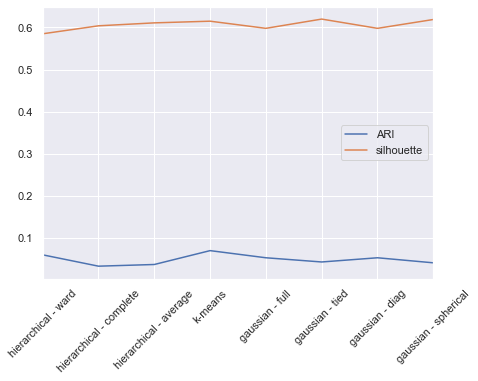

In [85]:
results_df.plot(figsize=(7,5))
plt.xticks(rotation=45);

# Revisit computations for above amounts

## k-means - visualize

In [86]:
# silhouette
labels = KMeans(n_clusters=5).fit_predict(X_std)

In [89]:
pd.Series(labels).value_counts()

3    2155
1    2058
4    2030
0    1288
2    1253
dtype: int64

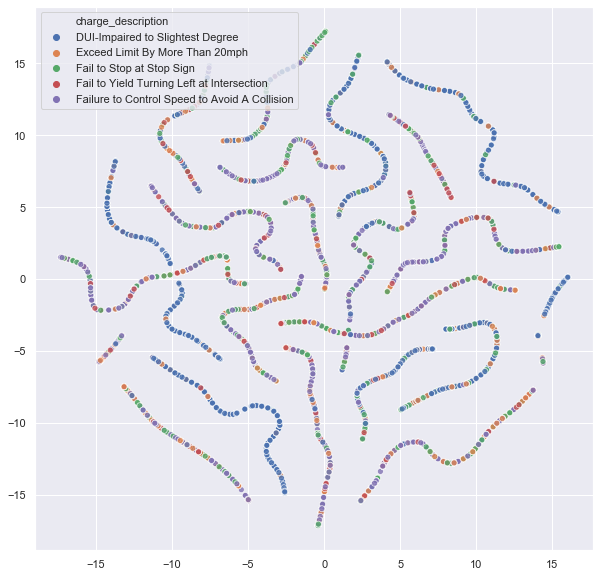

In [108]:
plt.figure(figsize=(10, 10))

sns.scatterplot(tsne_results[:, 0], 
            tsne_results[:, 1], 
            alpha=.8, 
            hue=five_citations['charge_description'].astype('category'))

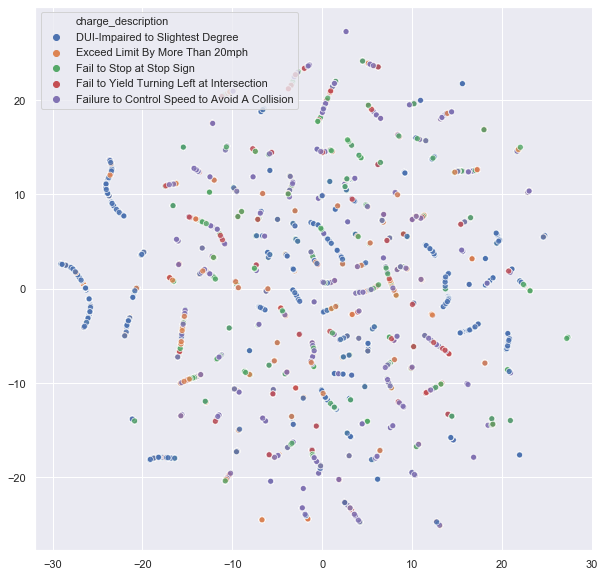

In [109]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0],
                y=umap_results[:, 1], 
                alpha=.8, 
                hue=five_citations['charge_description'].astype('category'))
plt.legend(loc='best')

# Add age with time of day

In [169]:
five_citations.head()

,arizona_statute_code,beat,charge_description,citation_#,citation_date,citation_time,citation_type_code,citation_type_description,cited_person,cited_person_age,cited_person_ethnicity,cited_person_race,cited_person_sex,city,district,officer_badge_#,state,street,street_number,zip,zone,tcmainid,month,day_of_week,week_of_year,hour_of_day
27,28-701A,1.0,Failure to Control Speed to Avoid A Collision,2087778,2019-07-15,1750,CV,Civil Traffic,"Flaaen-Hanna, Lynn",58.0,N,W,F,Scottsdale,D1,1501,AZ,N Hayden Rd / E McKellips Rd,xxx,NaN,103,662835,7,0,29,17
29,28-701.02A2,10.0,Exceed Limit By More Than 20mph,2087820,2019-07-15,1920,CT,Criminal Traffic,"Viadero, Patricio",22.0,N,W,M,Scottsdale,D3,1274,AZ,N Hayden Rd / E Via De Ventura,xxx,NaN,2606,662839,7,0,29,19
31,28-701.02A2,5.0,Exceed Limit By More Than 20mph,2089352,2019-07-15,1927,CT,Criminal Traffic,"Rogers, Sierra",22.0,N,W,F,Scottsdale,D2,1306,AZ,E Indian School Rd,8xxx,NaN,814,662842,7,0,29,19
32,28-701.02A2,1.0,Exceed Limit By More Than 20mph,2084967,2019-07-15,2030,CT,Criminal Traffic,"Sanchez Lopez, JOrge",19.0,H,W,M,Scottsdale,D1,1522,AZ,N Scottsdale Rd / E Skysong Bl,xxx,NaN,301,662845,7,0,29,20
36,28-701A,17.0,Failure to Control Speed to Avoid A Collision,2083769,2019-07-13,1126,CV,Civil Traffic,"Zajac, Rachel",22.0,N,W,F,Scottsdale,D4,1237,AZ,E Frank Lloyd Wright Bl / L101 Frontage Rd Nb,xxx,85260,3404,662851,7,5,28,11


In [170]:
# assign X and y values
X = pd.get_dummies(five_citations[['citation_time', 
                                   'cited_person_age',
                                  'cited_person_sex']])

y = five_citations['charge_description'].astype('category')

In [171]:
X.head()

,citation_time,cited_person_age,cited_person_sex_F,cited_person_sex_M
27,1750,58.0,1,0
29,1920,22.0,0,1
31,1927,22.0,1,0
32,2030,19.0,0,1
36,1126,22.0,1,0


In [172]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

### No matter what I try I am not able to get more than one cluster using DBSCAN

In [165]:
# adjust min_samples parameter

min_samples = []
cluster_count_min_samples = []

for i in range(1,1001,100):
    # Defining the agglomerative clustering
    dbscan_cluster = DBSCAN(eps=1, min_samples=i)
    min_samples.append(i)
    
    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    cluster_count_min_samples.append(len(set(clusters)) - (1 if -1 in clusters else 0))
    
cluster_count_min_samples

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [164]:
# adjust eps parameter

eps = []
cluster_count_eps = []

for i in range(1,1001,100):
    # Defining the agglomerative clustering
    dbscan_cluster = DBSCAN(eps=i, min_samples=1)
    eps.append(i)
    
    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    cluster_count_eps.append(len(set(clusters)) - (1 if -1 in clusters else 0))
        
cluster_count_eps

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [160]:
# combine results
pd.DataFrame(data= {'min_samples': cluster_count_min_samples,
                      'eps': cluster_count_eps},
            index=range(1,11,1))

,min_samples,eps
1,1,1
2,1,1
3,1,1
4,1,1
5,1,1
6,1,1
7,1,1
8,1,1
9,1,1
10,1,1


Text(0, 0.5, 'Clusters')

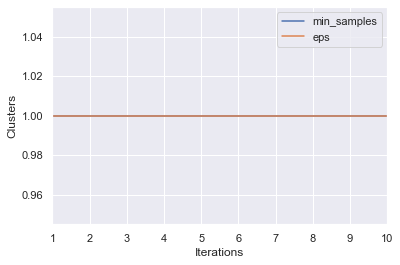

In [161]:
pd.DataFrame(data= {'min_samples': cluster_count_min_samples,
                      'eps': cluster_count_eps},
            index=range(1,11,1)).plot()
plt.xlabel('Iterations')
plt.ylabel('Clusters')

## VISUALIZE CLUSTERS

### PCA

In [173]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

In [174]:
y.value_counts()

DUI-Impaired to Slightest Degree                 2742
Failure to Control Speed to Avoid A Collision    2670
Fail to Stop at Stop Sign                        1469
Exceed Limit By More Than 20mph                  1257
Fail to Yield Turning Left at Intersection        646
Name: charge_description, dtype: int64

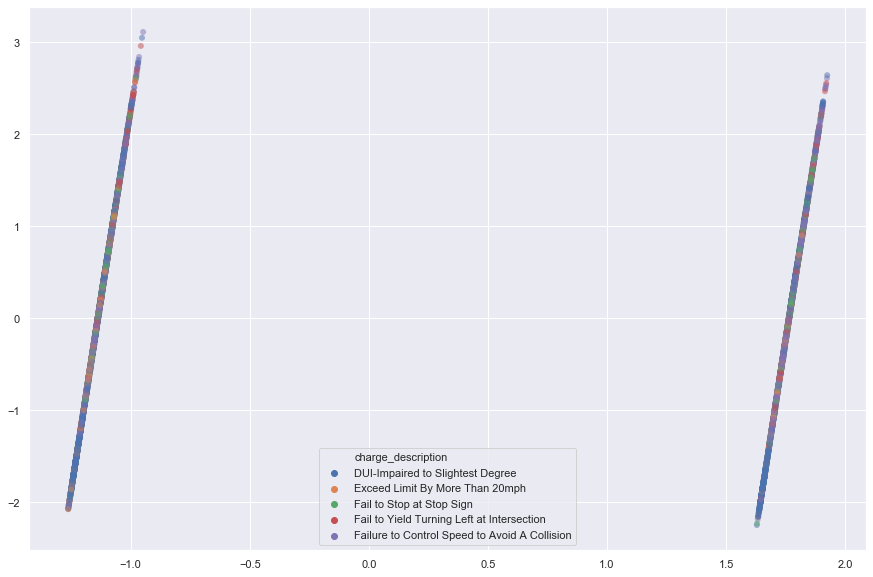

In [175]:
plt.figure(figsize=(15,10))

sns.scatterplot(X_pca[:, 0], X_pca[:, 1], hue=y, alpha=.5, edgecolor='none')

### t-SNE

In [176]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8784 samples in 0.004s...
[t-SNE] Computed neighbors for 8784 samples in 0.170s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8784
[t-SNE] Computed conditional probabilities for sample 2000 / 8784
[t-SNE] Computed conditional probabilities for sample 3000 / 8784
[t-SNE] Computed conditional probabilities for sample 4000 / 8784
[t-SNE] Computed conditional probabilities for sample 5000 / 8784
[t-SNE] Computed conditional probabilities for sample 6000 / 8784
[t-SNE] Computed conditional probabilities for sample 7000 / 8784
[t-SNE] Computed conditional probabilities for sample 8000 / 8784
[t-SNE] Computed conditional probabilities for sample 8784 / 8784
[t-SNE] Mean sigma: 5.646703
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.009624
[t-SNE] KL divergence after 300 iterations: 1.774401


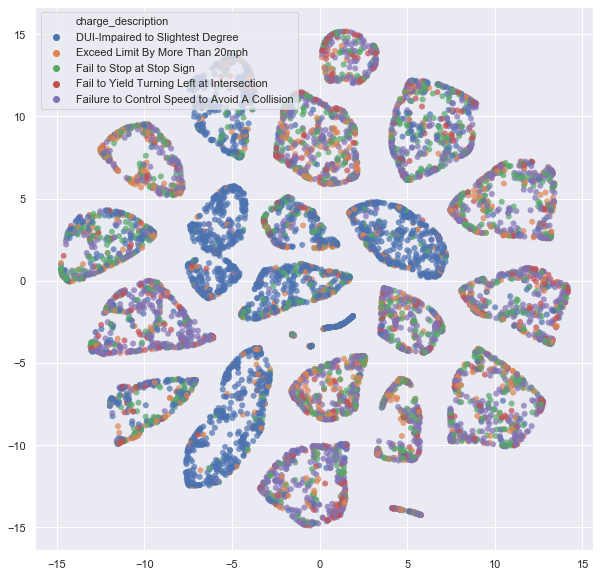

In [177]:
plt.figure(figsize=(10, 10))

sns.scatterplot(tsne_results[:, 0], tsne_results[:, 1], alpha=.7, hue=y, edgecolor='none')

### UMAP

In [178]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

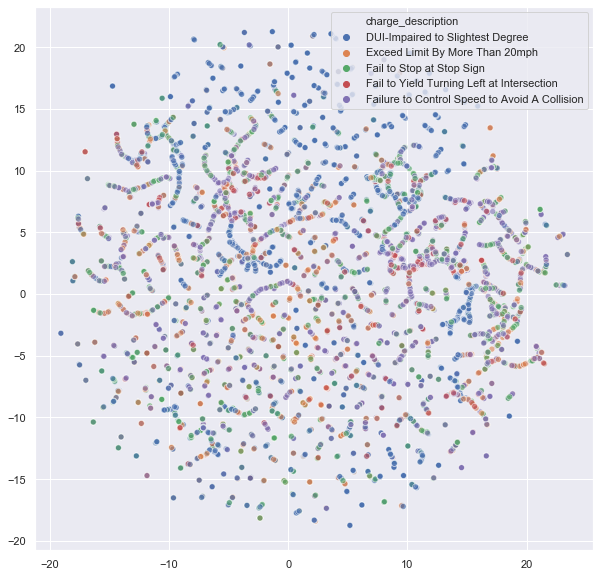

In [180]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], alpha=.6, hue=y)
plt.legend(loc='best')

In [181]:
umap_results = umap.UMAP(n_neighbors=20,
                      min_dist=0.1,
                      metric='correlation').fit_transform(X)

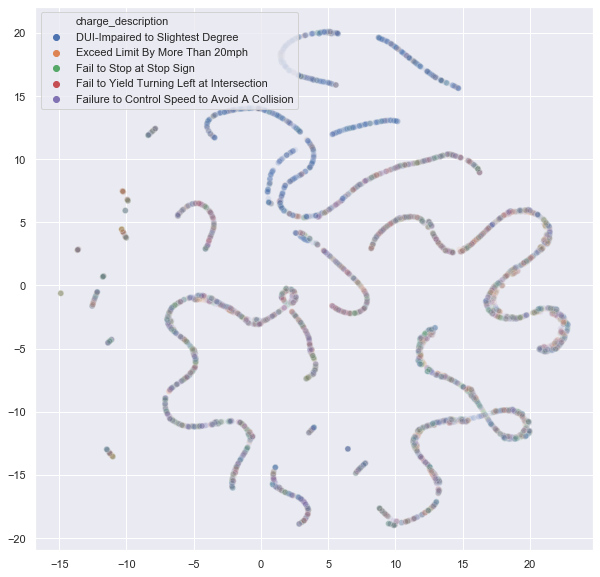

In [182]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], alpha=.1, hue=y)
plt.legend(loc='best')

In [183]:
umap_results = umap.UMAP(n_neighbors=100,
                      min_dist=1,
                      metric='correlation').fit_transform(X)

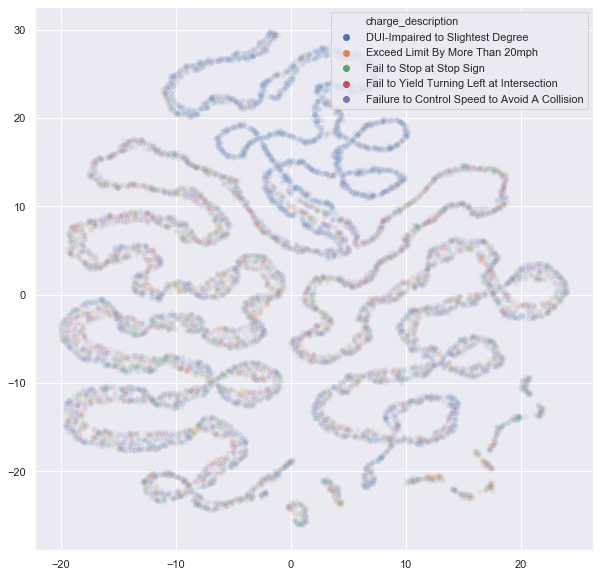

In [184]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], alpha=.1, hue=y)
plt.legend(loc='best')

## GROUP CLUSTERS AND EXAMINE FIT OF GROUPINGS

In [60]:
# create df to hold results of each iteration

rows = ['hierarchical - ward',
       'hierarchical - complete',
       'hierarchical - average',
       'k-means',
       'gaussian - full',
       'gaussian - tied',
       'gaussian - diag',
       'gaussian - spherical']

columns = ['ARI',
          'silhouette']

results_df = pd.DataFrame(index=rows,
                         columns=columns)

## K-means with 5 clusters

In [61]:
# silhouette
labels = KMeans(n_clusters=5).fit_predict(X_std)

results_df.loc['k-means', 'silhouette'] = round(metrics.silhouette_score(X_std, labels, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, labels, metric='euclidean'), 3)

0.615

In [62]:
# ARI
y_pred = KMeans(n_clusters=5).fit_predict(X_std)

results_df.loc['k-means', 'ARI'] = round(metrics.adjusted_rand_score(y, y_pred), 3)
round(metrics.adjusted_rand_score(y, y_pred), 3)

0.069

## Agglomerative methods

### 1. Ward - In general, this method tends to find clusters of similar size

In [63]:
# Defining the agglomerative clustering
# remember, ward only works with Euclidian
agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=5)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [64]:
# examine Adjusted Rand Index (ARI) and the silhouette scores
results_df.loc['hierarchical - ward', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.059

In [65]:
# examine silhouette score
results_df.loc['hierarchical - ward', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.585

### 2. Complete - Clusters tend to be comprised of highly similar observations, making the resulting groups quite compact.

In [66]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=5)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [67]:
# examine Adjusted Rand Index (ARI) and the silhouette scores
results_df.loc['hierarchical - complete', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.032

In [68]:
# examine silhouette score
results_df.loc['hierarchical - complete', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.604

### 3. Average - it tends to create larger groups than the complete method. Moreover, the clusters can be different sizes and shapes in contrast to the Ward method.

In [69]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='cosine',
                                      n_clusters=5)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [70]:
# examine Adjusted Rand Index (ARI) and the silhouette scores
results_df.loc['hierarchical - average', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.036

In [71]:
# examine silhouette score
results_df.loc['hierarchical - average', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.611

## Gausian Mixture Modeling
Explore each covariance_type parameter:

 1. full: This is the default. Each component has its own general covariance matrix.
 1. tied: All components share the same general covariance matrix.
 1. diag: Each component has its own diagonal covariance matrix.
 1. spherical: Each component has its own single variance.

## full

In [72]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [73]:
# Examine ARI and silhouette score
results_df.loc['gaussian - full', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.598

In [74]:
results_df.loc['gaussian - full', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.052

## tied

In [75]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123, covariance_type='tied')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [76]:
# Examine ARI and silhouette score
results_df.loc['gaussian - tied', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.62

In [77]:
results_df.loc['gaussian - tied', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.042

## diag

In [78]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123, covariance_type='diag')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [79]:
# Examine ARI and silhouette score
results_df.loc['gaussian - diag', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.598

In [80]:
results_df.loc['gaussian - diag', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.052

## spherical

In [81]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123, covariance_type='spherical')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

In [82]:
# Examine ARI and silhouette score
results_df.loc['gaussian - spherical', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.619

In [83]:
results_df.loc['gaussian - spherical', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.04

In [84]:
results_df

,ARI,silhouette
hierarchical - ward,0.059,0.585
hierarchical - complete,0.032,0.604
hierarchical - average,0.036,0.611
k-means,0.069,0.615
gaussian - full,0.052,0.598
gaussian - tied,0.042,0.62
gaussian - diag,0.052,0.598
gaussian - spherical,0.04,0.619


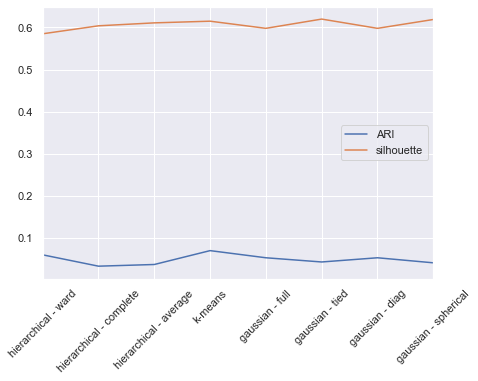

In [85]:
results_df.plot(figsize=(7,5))
plt.xticks(rotation=45);

# Revisit computations for above amounts

## k-means - visualize

In [136]:
# silhouette
labels = KMeans(n_clusters=5).fit_predict(X_std)

In [141]:
pd.Series(labels).apply(str)

0       3
1       1
2       1
3       1
4       4
       ..
8779    3
8780    1
8781    0
8782    1
8783    1
Length: 8784, dtype: object

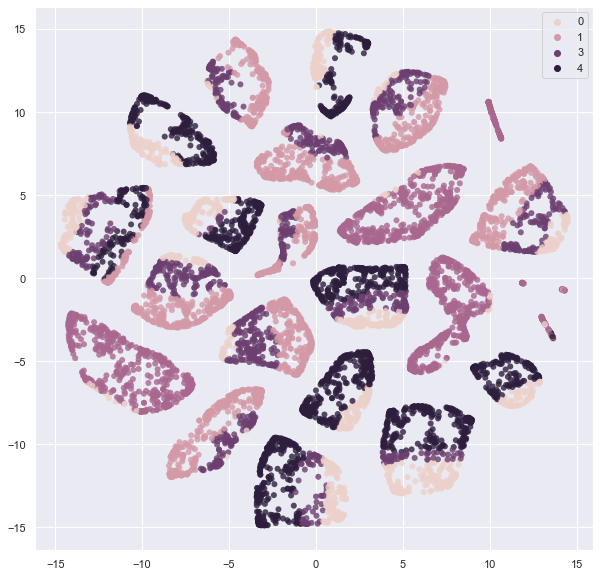

In [151]:
plt.figure(figsize=(10, 10))

sns.scatterplot(tsne_results[:, 0], 
            tsne_results[:, 1], 
            alpha=.8, 
            hue=pd.Series(labels),
               edgecolor='none')

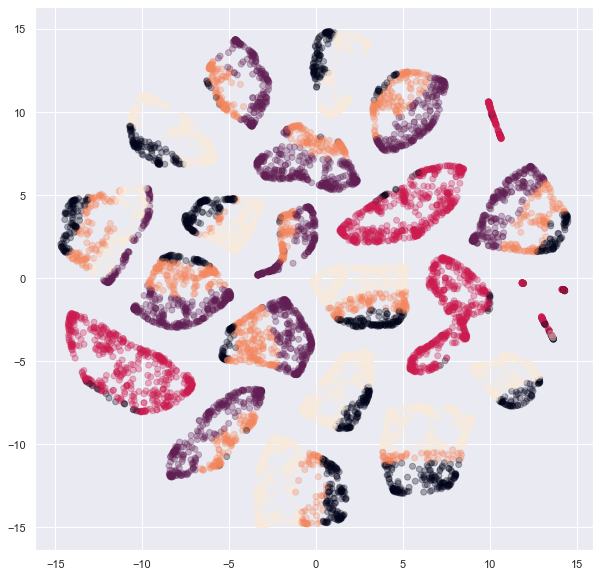

In [149]:
plt.figure(figsize=(10, 10))

plt.scatter(tsne_results[:, 0], 
            tsne_results[:, 1], 
            alpha=.3, 
            c=pd.Series(labels))

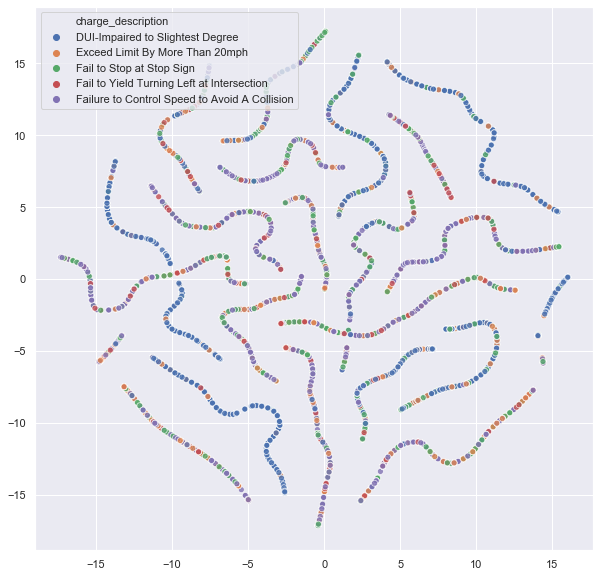

In [108]:
plt.figure(figsize=(10, 10))

sns.scatterplot(tsne_results[:, 0], 
            tsne_results[:, 1], 
            alpha=.8, 
            hue=five_citations['charge_description'].astype('category'))

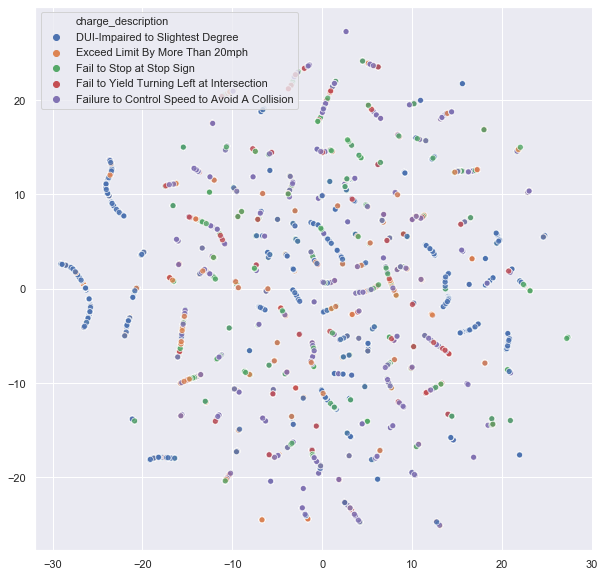

In [109]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=umap_results[:, 0],
                y=umap_results[:, 1], 
                alpha=.8, 
                hue=five_citations['charge_description'].astype('category'))
plt.legend(loc='best')